## Dependencias

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',200)

## Lectura de datos

In [80]:
df = pd.read_csv('/home/jose/Documentos/bd/lending club/acc.csv').sample(200000)
df.shape

(200000, 151)

In [81]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
476102,128023024,NaN,6000.0,6000.0,6000.0,36 months,10.91,196.18,B,B4,Owner,6 years,OWN,30000.0,Verified,Feb-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,804xx,CO,28.16,0.0,Nov-1982,660.0,664.0,0.0,NaN,66.0,8.0,1.0,10330.0,67.1,38.0,w,4054.95,4054.95,2541.25,2541.25,1945.05,596.20,0.0,0.0,0.0,Mar-2019,196.18,Apr-2019,Mar-2019,684.0,680.0,0.0,NaN,1.0,Joint App,80000.0,12.04,Verified,0.0,0.0,65302.0,1.0,2.0,1.0,2.0,10.0,54972.0,75.0,3.0,3.0,6571.0,71.0,15400.0,1.0,1.0,2.0,5.0,8163.0,3903.0,71.9,0.0,0.0,162.0,422.0,3.0,3.0,2.0,3.0,NaN,10.0,NaN,0.0,5.0,6.0,5.0,11.0,17.0,6.0,19.0,6.0,8.0,0.0,0.0,0.0,4.0,100.0,40.0,1.0,0.0,73294.0,65302.0,13900.0,57894.0,10330.0,600.0,604.0,Sep-1980,1.0,2.0,2.0,NaN,1.0,13.0,0.0,0.0,45.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2083497,124420072,NaN,10000.0,10000.0,10000.0,36 months,10.42,324.65,B,B3,Salesperson,7 years,MORTGAGE,70000.0,Source Verified,Nov-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,294xx,SC,12.17,0.0,Mar-1993,695.0,699.0,2.0,NaN,52.0,30.0,5.0,17045.0,27.0,35.0,w,5936.80,5936.80,5188.61,5188.61,4063.20,1125.41,0.0,0.0,0.0,Mar-2019,324.65,Apr-2019,Mar-2019,614.0,610.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,199289.0,7.0,1.0,0.0,0.0,28.0,1340.0,34.0,9.0,20.0,8045.0,27.0,63100.0,0.0,0.0,3.0,20.0,6643.0,33332.0,30.7,0.0,0.0,28.0,296.0,3.0,3.0,2.0,3.0,NaN,3.0,NaN,0.0,12.0,18.0,16.0,18.0,1.0,27.0,32.0,18.0,30.0,0.0,0.0,0.0,9.0,100.0,0.0,0.0,5.

### Pretratamiento

In [82]:
def freq(df,var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuencias para la variable **",v,"**","\n"*2)
        print(aux,"\n"*2)


In [83]:
fuera = ['pymnt_plan','url','zip_code','last_pymnt_d','last_pymnt_amnt',
         'next_pymnt_d','last_credit_pull_d']
fechas = ['issue_d','earliest_cr_line']
tgt = 'loan_status'

In [84]:
df[tgt] = (~df[tgt].isin(['Fully Paid','Current'])).astype(int)

In [85]:
d_meses = dict(zip(['Oct', 'Jul', 'Nov', 'Aug', 'Dec', 'Mar', 'May', 'Apr', 'Jun', 'Sep',
       'Jan', 'Feb'],[10,7,11,8,12,3,5,4,6,9,1,2]))

In [86]:
for f in fechas:
    df[f] = df[f].fillna('Dec-2099').map(lambda x:x.split('-'))
    df[f] = df[f].map(lambda x:str(x[1])+'-'+'%02d'%d_meses[x[0]]+'-01')
    df[f] = pd.to_datetime(df[f],errors='coerce')

In [87]:
df['tob'] = (df['issue_d']-df['earliest_cr_line'])/np.timedelta64(1,'Y')

## Selección de variables

In [88]:
vard = [c for c in df.columns if str in (df[c].map(type).unique())]

fuera = ['pymnt_plan','url','zip_code','last_pymnt_d','last_pymnt_amnt',
         'next_pymnt_d','last_credit_pull_d','id','sec_app_earliest_cr_line',
         'hardship_start_date','payment_plan_start_date','debt_settlement_flag_date',
         'settlement_date'
        ]
vard =[v for v in vard if v not in fuera]

In [89]:
varc = [c for c in df.columns if float in (df[c].map(type).unique()) and len(df[c].map(type).unique())==1]

In [90]:
um = ['id']

## Análisis Exploratorio de Datos

### Discreto

#### Frecuencias

In [91]:
freq(df,vard)

Tabla de frecuencias para la variable ** term ** 


                FA        FR     FAA       FRA
 36 months  142613  0.713083  142613  0.713083
 60 months   57382  0.286917  199995  1.000000 


Tabla de frecuencias para la variable ** grade ** 


      FA        FR     FAA       FRA
B  58587  0.292942   58587  0.292942
C  57321  0.286612  115908  0.579554
A  38635  0.193180  154543  0.772734
D  28806  0.144034  183349  0.916768
E  11852  0.059261  195201  0.976029
F   3747  0.018735  198948  0.994765
G   1047  0.005235  199995  1.000000 


Tabla de frecuencias para la variable ** sub_grade ** 


       FA        FR     FAA       FRA
C1  12989  0.064947   12989  0.064947
B5  12342  0.061712   25331  0.126658
B4  12239  0.061197   37570  0.187855
B3  11689  0.058446   49259  0.246301
C2  11564  0.057821   60823  0.304123
B1  11301  0.056506   72124  0.360629
C3  11244  0.056221   83368  0.416850
C4  11201  0.056006   94569  0.472857
B2  11016  0.055081  105585  0.527938
C5  10323  0.05

Tabla de frecuencias para la variable ** hardship_end_date ** 


           FA        FR  FAA       FRA
Dec-2017  149  0.162309  149  0.162309
Nov-2017  109  0.118736  258  0.281046
Jan-2018   57  0.062092  315  0.343137
Jan-2019   51  0.055556  366  0.398693
Oct-2017   44  0.047930  410  0.446623
Feb-2019   43  0.046841  453  0.493464
Dec-2018   41  0.044662  494  0.538126
Sep-2017   38  0.041394  532  0.579521
Nov-2018   37  0.040305  569  0.619826
Oct-2018   34  0.037037  603  0.656863
Apr-2019   33  0.035948  636  0.692810
Mar-2019   32  0.034858  668  0.727669
Aug-2017   32  0.034858  700  0.762527
Apr-2018   31  0.033769  731  0.796296
Mar-2018   29  0.031590  760  0.827887
Feb-2018   27  0.029412  787  0.857298
Aug-2018   26  0.028322  813  0.885621
Sep-2018   24  0.026144  837  0.911765
May-2018   16  0.017429  853  0.929194
May-2019   15  0.016340  868  0.945534
Jul-2018   14  0.015251  882  0.960784
Jun-2019   12  0.013072  894  0.973856
Jun-2018   11  0.011983  905  0.985839

In [92]:
for v in vard:
    df[v].fillna('MISSING',inplace=True)

#### Normalización

In [96]:
def normalizar(df,v,umbral=0.03):
    aux = df[v].value_counts(True).to_frame()
    aux[f'norm_{v}'] = np.where(aux[v]<umbral,'SMALL CATEGORIES',aux.index)
    moda = aux.head(1)[f'norm_{v}'].values[0]
    if aux.loc[aux[f'norm_{v}']=='SMALL CATEGORIES'][v].sum()<umbral:
        aux[f'norm_{v}'].replace({'SMALL CATEGORIES':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    aux.reset_index(inplace=True)
    return df.merge(aux,left_on=v,right_on='index',how='inner').drop('index',axis=1)

In [97]:
for v in vard:
    df = normalizar(df,v)

In [98]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,tob,norm_term,norm_grade,norm_sub_grade,norm_emp_title,norm_emp_length,norm_home_ownership,norm_verification_status,norm_desc,norm_purpose,norm_title,norm_addr_state,norm_initial_list_status,norm_application_type,norm_verification_status_joint,norm_hardship_flag,norm_hardship_type,norm_hardship_reason,norm_hardship_status,norm_hardship_end_date,norm_hardship_loan_status,norm_disbursement_method,norm_debt_settlement_flag,norm_settlement_status
0,128023024,NaN,6000.0,6000.0,6000.0,36 months,10.91,196.18,B,B4,Owner,6 years,OWN,30000.0,Verified,2018-02-01,0,n,https://lendingclub.com/browse/loanDetail.acti...,MISSING,debt_consolidation,Debt consolidation,804xx,CO,28.16,0.0,1982-11-01,660.0,664.0,0.0,NaN,66.0,8.0,1.0,10330.0,67.1,38.0,w,4054.95,4054.95,2541.25,2541.25,1945.05,596.20,0.0,0.0,0.0,Mar-2019,196.18,Apr-2019,Mar-2019,684.0,680.0,0.0,NaN,1.0,Joint App,80000.0,12.04,Verified,0.0,0.0,65302.0,1.0,2.0,1.0,2.0,10.0,54972.0,75.0,3.0,3.0,6571.0,71.0,15400.0,1.0,1.0,2.0,5.0,8163.0,3903.0,71.9,0.0,0.0,162.0,422.0,3.0,3.0,2.0,3.0,NaN,10.0,NaN,0.0,5.0,6.0,5.0,11.0,17.0,6.0,19.0,6.0,8.0,0.0,0.0,0.0,4.0,100.0,40.0,1.0,0.0,73294.0,65302.0,13900.0,57894.0,10330.0,600.0,604.0,Sep-1980,1.0,2.0,2.0,NaN,1.0,13.0,0.0,0.0,45.0,N,MISSING,MISSING,MISSING,NaN,NaN,NaN,MISSING,NaN,NaN,NaN,MISSING,NaN,NaN,NaN,Cash,N,NaN,MISSING,NaN,NaN,NaN,NaN,35.253291,36 months,B,B4,SMALL CATEGORIES,6 years,OWN,Verified,MISSING,debt_consolidation,Debt consolidation,SMALL CATEGORIES,w,Joint App,SMALL CATEGORIES,N,MISSING,MISSING,MISSING,MISSING,MISSING,Cash,N,MISSING
1,119697191,NaN,20000.

In [99]:
varn = df.filter(like='norm_').columns.tolist()

In [100]:
varn

['norm_term',
 'norm_grade',
 'norm_sub_grade',
 'norm_emp_title',
 'norm_emp_length',
 'norm_home_ownership',
 'norm_verification_status',
 'norm_desc',
 'norm_purpose',
 'norm_title',
 'norm_addr_state',
 'norm_initial_list_status',
 'norm_application_type',
 'norm_verification_status_joint',
 'norm_hardship_flag',
 'norm_hardship_type',
 'norm_hardship_reason',
 'norm_hardship_status',
 'norm_hardship_end_date',
 'norm_hardship_loan_status',
 'norm_disbursement_method',
 'norm_debt_settlement_flag',
 'norm_settlement_status']

In [101]:
freq(df,varn)

Tabla de frecuencias para la variable ** norm_term ** 


                FA       FR     FAA      FRA
 36 months  142618  0.71309  142618  0.71309
 60 months   57382  0.28691  200000  1.00000 


Tabla de frecuencias para la variable ** norm_grade ** 


      FA        FR     FAA       FRA
B  63386  0.316930   63386  0.316930
C  57321  0.286605  120707  0.603535
A  38635  0.193175  159342  0.796710
D  28806  0.144030  188148  0.940740
E  11852  0.059260  200000  1.000000 


Tabla de frecuencias para la variable ** norm_sub_grade ** 


                     FA        FR     FAA       FRA
SMALL CATEGORIES  31625  0.158125   31625  0.158125
C1                12989  0.064945   44614  0.223070
B5                12342  0.061710   56956  0.284780
B4                12239  0.061195   69195  0.345975
B3                11689  0.058445   80884  0.404420
C2                11564  0.057820   92448  0.462240
B1                11301  0.056505  103749  0.518745
C3                11244  0.056220  114993  0

#### Unarias

In [102]:
unarias = [v for v,conteo in zip(varn,[df[v].unique().shape[0] for v in varn]) if conteo==1]

In [103]:
unarias

['norm_hardship_flag',
 'norm_hardship_type',
 'norm_hardship_reason',
 'norm_hardship_status',
 'norm_hardship_end_date',
 'norm_hardship_loan_status',
 'norm_debt_settlement_flag',
 'norm_settlement_status']

In [104]:
varn = [v for v in varn if v not in unarias]
varn

['norm_term',
 'norm_grade',
 'norm_sub_grade',
 'norm_emp_title',
 'norm_emp_length',
 'norm_home_ownership',
 'norm_verification_status',
 'norm_desc',
 'norm_purpose',
 'norm_title',
 'norm_addr_state',
 'norm_initial_list_status',
 'norm_application_type',
 'norm_verification_status_joint',
 'norm_disbursement_method']

In [105]:
freq(df,varn)

Tabla de frecuencias para la variable ** norm_term ** 


                FA       FR     FAA      FRA
 36 months  142618  0.71309  142618  0.71309
 60 months   57382  0.28691  200000  1.00000 


Tabla de frecuencias para la variable ** norm_grade ** 


      FA        FR     FAA       FRA
B  63386  0.316930   63386  0.316930
C  57321  0.286605  120707  0.603535
A  38635  0.193175  159342  0.796710
D  28806  0.144030  188148  0.940740
E  11852  0.059260  200000  1.000000 


Tabla de frecuencias para la variable ** norm_sub_grade ** 


                     FA        FR     FAA       FRA
SMALL CATEGORIES  31625  0.158125   31625  0.158125
C1                12989  0.064945   44614  0.223070
B5                12342  0.061710   56956  0.284780
B4                12239  0.061195   69195  0.345975
B3                11689  0.058445   80884  0.404420
C2                11564  0.057820   92448  0.462240
B1                11301  0.056505  103749  0.518745
C3                11244  0.056220  114993  0

### Continuas

### Ausentes

In [125]:
df = df.loc[~df['loan_amnt'].isnull()].reset_index(drop=True)

In [126]:
miss = 1-df[varc].describe().T[['count']]/len(df)

In [127]:
miss = miss.loc[miss['count']<=0.3].reset_index()

In [132]:
varc = miss['index'].tolist()

#### Discretización

In [162]:
def discretizar(df,v,k):
    aux = df[[v]+um].copy()
    lm = [d for _,d in aux.groupby(df[v].isnull())]
    if len(lm)==2:
        nomiss,miss = lm
    else:
        nomiss = lm[0]
        miss = nomiss.loc[nomiss.index<0].reset_index(drop=True)
    
    miss.fillna('MISSING',inplace=True)
    
    kb = KBinsDiscretizer(n_bins=k,
                          encode='ordinal',
                          strategy='quantile')
    kb.fit(nomiss[[v]])
    
    nomiss[f'd_{v}_{k}'] = pd.cut(nomiss[v],bins=kb.bin_edges_[0].tolist(),
                                  include_lowest=True).astype(str) 
    miss[f'd_{v}_{k}'] = 'MISSING'
    
    return pd.concat([nomiss,miss],ignore_index=True)[um+[f'd_{v}_{k}']]

In [163]:
discretizar(df,'total_rev_hi_lim',3)

,id,d_total_rev_hi_lim_3
0,128023024,"(-0.001, 17900.0]"
1,119697191,"(-0.001, 17900.0]"
2,143598452,"(35900.0, 1514001.0]"
3,140447151,"(35900.0, 1514001.0]"
4,113151250,"(-0.001, 17900.0]"
...,...,...
199990,607637,MISSING
199991,752742,MISSING
199992,1058301,MISSING
199993,352645,MISSING


In [164]:
ld = []
for v in varc:
    for k in range(2,6):
        ld.append(discretizar(df,v,k))

In [174]:
dfd = reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),ld)

In [178]:
vari = dfd.filter(like='d_').columns.tolist()

In [179]:
df = df.merge(dfd,on=um,how='inner')

In [190]:
def calculo_iv(df,v,tgt):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0)
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['w']
    return v,aux['iv'].sum()

### Partición de datos



In [191]:
var = (vari+varn)[:]

In [233]:
X = df[var+um].copy()
y = df[[tgt]+um].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7,random_state=2000)
Xt = Xt.merge(yt,on=um,how='inner')

In [238]:
iv = pd.DataFrame(map(lambda v:calculo_iv(Xt,v,tgt),var),columns=['variable','iv'])

iv['raiz'] = iv['variable'].map(lambda x:"_".join(x.split('_')[1:-1]) if x[:2]=='d_' else x)
iv = iv.loc[~np.isinf(iv['iv'])].reset_index(drop=True)

iv = iv.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)

iv['id'] = iv.groupby('raiz').cumcount()+1

iv = iv.loc[(iv['id']==1)&((iv['iv']>=0.05))&((iv['iv']<=0.6))]

In [239]:
iv.sort_values(by='iv',ascending=False)

,variable,iv,raiz,id
118,norm_sub_grade,0.487952,norm_sub_grade,1
60,d_int_rate_5,0.406931,int_rate,1
114,norm_grade,0.367934,norm_grade,1
251,d_total_pymnt_inv_5,0.213134,total_pymnt_inv,1
247,d_total_pymnt_5,0.211634,total_pymnt,1
36,d_fico_range_high_5,0.139745,fico_range_high,1
40,d_fico_range_low_5,0.139745,fico_range_low,1
12,d_bc_open_to_buy_5,0.091425,bc_open_to_buy,1
0,d_acc_open_past_24mths_5,0.082599,acc_open_past_24mths,1
121,norm_verification_status,0.079496,norm_verification_status,1


In [240]:
best = iv['variable'].tolist()
best.remove('d_total_pymnt_inv_5')
best.remove('d_total_pymnt_5')
len(best),len(set(best))

(12, 12)

## Transformación WoE

In [241]:
X = df[best+um].copy()
y = df[[tgt]+um].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7,random_state=2000)
Xt = Xt.merge(yt,on=um,how='inner')

In [242]:
def codificacion_woe(df,v,tgt):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um[0],
                         aggfunc='count',
                         fill_value=0)
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    aux = aux.to_dict()['w']
    return v,aux

In [243]:
mapa_woe = list(map(lambda v:codificacion_woe(Xt,v,tgt),best))

In [244]:
for v,mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [245]:
Xt.shape,Xt.dropna().shape

((139996, 26), (139996, 26))

In [246]:
Xv.shape,Xv.dropna().shape

((59999, 25), (59999, 25))

In [247]:
Xt.head(2)

,d_acc_open_past_24mths_5,d_bc_open_to_buy_5,d_fico_range_high_5,d_fico_range_low_5,d_int_rate_5,d_mo_sin_rcnt_tl_5,norm_grade,norm_sub_grade,norm_term,norm_verification_status,d_num_tl_op_past_12m_4,d_total_bc_limit_5,id,loan_status,w_d_acc_open_past_24mths_5,w_d_bc_open_to_buy_5,w_d_fico_range_high_5,w_d_fico_range_low_5,w_d_int_rate_5,w_d_mo_sin_rcnt_tl_5,w_norm_grade,w_norm_sub_grade,w_norm_term,w_norm_verification_status,w_d_num_tl_op_past_12m_4,w_d_total_bc_limit_5
0,"(3.0, 5.0]","(17733.8, 357467.0]","(674.0, 689.0]","(670.0, 685.0]","(16.99, 30.99]","(-0.001, 2.0]",E,SMALL CATEGORIES,60 months,Verified,"(2.0, 3.0]","(35300.0, 1090700.0]",132990072,0,0.003323,0.599399,-0.176561,-0.176561,-0.772397,-0.232522,-1.005500,-0.898328,-0.374068,-0.320108,-0.192139,0.476268
1,"(-0.001, 2.0]","(1217.0, 3665.0]","(613.999, 674.0]","(609.999, 670.0]","(13.66, 16.99]","(4.0, 7.0]",C,C4,36 months,Verified,"(1.0, 2.0]","(20700.0, 35300.0]",55159451,0,0.384913,-0.197775,-0.388810,-0.388810,-0.281493,-0.019662,-0.119643,-0.270281,0.184347,-0.320108,0.018696,0.150392


In [248]:
varw = [v for v in Xt.columns if v[:2]=='w_']
varw,len(varw)

(['w_d_acc_open_past_24mths_5',
  'w_d_bc_open_to_buy_5',
  'w_d_fico_range_high_5',
  'w_d_fico_range_low_5',
  'w_d_int_rate_5',
  'w_d_mo_sin_rcnt_tl_5',
  'w_norm_grade',
  'w_norm_sub_grade',
  'w_norm_term',
  'w_norm_verification_status',
  'w_d_num_tl_op_past_12m_4',
  'w_d_total_bc_limit_5'],
 12)

## Ajuste del modelo logístico

In [249]:
modelo = LogisticRegression()

In [250]:
modelo.fit(Xt[varw],yt[tgt])

LogisticRegression()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

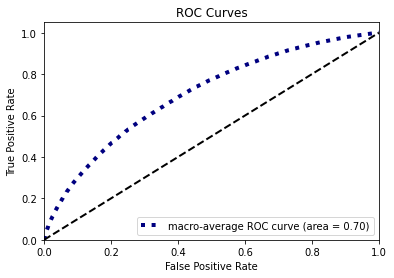

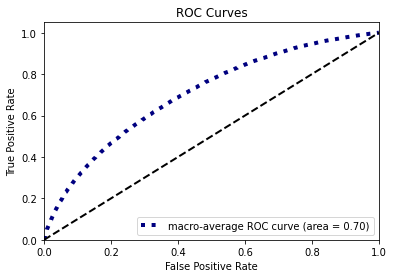

In [251]:
plot_roc_curve(y_true=yt[tgt],y_probas=modelo.predict_proba(Xt[varw]),curves='macro')
plot_roc_curve(y_true=yv[tgt],y_probas=modelo.predict_proba(Xv[varw]),curves='macro')

## Transformación Scoring

In [287]:
PDO = 27
base_score = 745-370
base_odds = 2
factor = PDO / np.log(2)
offset = base_score-factor*np.log(base_odds)
print(factor,offset)

38.952766104002016 348.0


In [288]:
betas = modelo.coef_[0].tolist()
beta0 = modelo.intercept_[0]

In [289]:
n = len(betas)
n

12

In [290]:
for v,beta in zip(varw,betas):
    Xt[f'p_{v}'] = np.ceil((-Xt[v]*beta+beta0/n)*factor+offset/n)
    Xv[f'p_{v}'] = np.ceil((-Xv[v]*beta+beta0/n)*factor+offset/n)

In [291]:
varp = [v for v in Xt.columns if v[:2]=='p_']
varp,len(varp)

(['p_w_d_acc_open_past_24mths_5',
  'p_w_d_bc_open_to_buy_5',
  'p_w_d_fico_range_high_5',
  'p_w_d_fico_range_low_5',
  'p_w_d_int_rate_5',
  'p_w_d_mo_sin_rcnt_tl_5',
  'p_w_norm_grade',
  'p_w_norm_sub_grade',
  'p_w_norm_term',
  'p_w_norm_verification_status',
  'p_w_d_num_tl_op_past_12m_4',
  'p_w_d_total_bc_limit_5'],
 12)

In [292]:
Xt['score'] = Xt[varp].sum(axis=1)
Xv['score'] = Xv[varp].sum(axis=1)

<AxesSubplot:xlabel='score', ylabel='Density'>

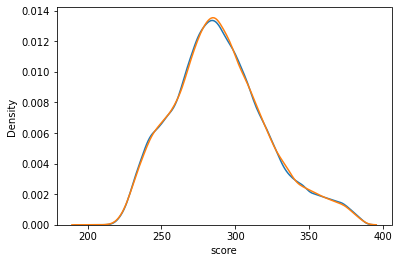

In [293]:
sns.distplot(Xt['score'],hist=False)
sns.distplot(Xv['score'],hist=False)

### Crear scorecard

In [294]:
lsc = []
for vi,vp in zip([v[2:] for v in varw],varp):
    aux = Xt[[vi,vp]].drop_duplicates()
    aux = aux.sort_values(by=vi,ascending=True).reset_index(drop=True)
    aux.columns = ['atributo','puntos']
    aux['caracteristica'] = vi
    lsc.append(aux)

In [295]:
scorecard = pd.concat(lsc,ignore_index=True)

In [296]:
scorecard = scorecard.groupby(['caracteristica','atributo']).sum('puntos')

In [297]:
scorecard.to_excel('scorecard_lending_club.xlsx')

In [298]:
df.sample(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,...,d_mths_since_recent_bc_2,d_mths_since_recent_bc_3,d_mths_since_recent_bc_4,d_mths_since_recent_bc_5,d_mths_since_recent_inq_2,d_mths_since_recent_inq_3,d_mths_since_recent_inq_4,d_mths_since_recent_inq_5,d_num_accts_ever_120_pd_2,d_num_accts_ever_120_pd_3,d_num_accts_ever_120_pd_4,d_num_accts_ever_120_pd_5,d_num_actv_bc_tl_2,d_num_actv_bc_tl_3,d_num_actv_bc_tl_4,d_num_actv_bc_tl_5,d_num_actv_rev_tl_2,d_num_actv_rev_tl_3,d_num_actv_rev_tl_4,d_num_actv_rev_tl_5,d_num_bc_sats_2,d_num_bc_sats_3,d_num_bc_sats_4,d_num_bc_sats_5,d_num_bc_tl_2,d_num_bc_tl_3,d_num_bc_tl_4,d_num_bc_tl_5,d_num_il_tl_2,d_num_il_tl_3,d_num_il_tl_4,d_num_il_tl_5,d_num_op_rev_tl_2,d_num_op_rev_tl_3,d_num_op_rev_tl_4,d_num_op_rev_tl_5,d_num_rev_accts_2,d_num_rev_accts_3,d_num_rev_accts_4,d_num_rev_accts_5,d_num_rev_tl_bal_gt_0_2,d_num_rev_tl_bal_gt_0_3,d_num_rev_tl_bal_gt_0_4,d_num_rev_tl_bal_gt_0_5,d_num_sats_2,d_num_sats_3,d_num_sats_4,d_num_sats_5,d_num_tl_120dpd_2m_2,d_num_tl_120dpd_2m_3,d_num_tl_120dpd_2m_4,d_num_tl_120dpd_2m_5,d_num_tl_30dpd_2,d_num_tl_30dpd_3,d_num_tl_30dpd_4,d_num_tl_30dpd_5,d_num_tl_90g_dpd_24m_2,d_num_tl_90g_dpd_24m_3,d_num_tl_90g_dpd_24m_4,d_num_tl_90g_dpd_24m_5,d_num_tl_op_past_12m_2,d_num_tl_op_past_12m_3,d_num_tl_op_past_12m_4,d_num_tl_op_past_12m_5,d_pct_tl_nvr_dlq_2,d_pct_tl_nvr_dlq_3,d_pct_tl_nvr_dlq_4,d_pct_tl_nvr_dlq_5,d_percent_bc_gt_75_2,d_percent_bc_gt_75_3,d_percent_bc_gt_75_4,d_percent_bc_gt_75_5,d_pub_rec_bankruptcies_2,d_pub_rec_bankruptcies_3,d_pub_rec_bankruptcies_4,d_pub_rec_bankruptcies_5,d_tax_liens_2,d_tax_liens_3,d_tax_liens_4,d_tax_liens_5,d_tot_hi_cred_lim_2,d_tot_hi_cred_lim_3,d_tot_hi_cred_lim_4,d_tot_hi_cred_lim_5,d_total_bal_ex_mort_2,d_total_bal_ex_mort_3,d_total_bal_ex_mort_4,d_total_bal_ex_mort_5,d_total_bc_limit_2,d_total_bc_limit_3,d_total_bc_limit_4,d_total_bc_limit_5,d_total_il_high_credit_limit_2,d_total_il_high_credit_limit_3,d_total_il_high_credit_limit_4,d_total_il_high_credit_limit_5,d_tob_2,d_tob_3,d_tob_4,d_tob_5
17392,142540044,NaN,35000.0,35000.0,35000.0,60 months,16.14,853.74,C,C4,paramedic,10+ years,RENT,96780.0,Source Verified,2018-10-01,1,n,https://lendingclub.com/browse/loanDetail.acti...,MISSING,debt_consolidation,Debt consolidation,773xx,TX,22.05,0.0,2002-01-01,730.0,734.0,1.0,NaN,NaN,10.0,0.0,18459.0,29.7,22.0,w,34617.01,34617.01,822.36,822.36,382.99,439.37,0.0,0.0,0.0,Dec-2018,853.74,Apr-2019,Mar-2019,504.0,500.0,0.0,NaN,1.0,Individual,NaN,NaN,MISSING,0.0,0.0,52488.0,0.0,2.0,1.0,1.0,8.0,34029.0,94.0,0.0,1.0,10945.0,37.0,62200.0,1.0,3.0,1.0,2.0,5249.0,31859.0,33.3,0.0,0.0,201.0,86.0,16.0,8.0,3.0,16.0,Na

In [299]:
Xt.score.describe()

count    139996.000000
mean        289.817359
std          32.475112
min         200.000000
25%         267.000000
50%         287.000000
75%         309.000000
max         385.000000
Name: score, dtype: float64

In [300]:
Xv.score.describe()

count    59999.000000
mean       289.935082
std         32.315676
min        200.000000
25%        268.000000
50%        288.000000
75%        309.000000
max        385.000000
Name: score, dtype: float64

In [307]:
aux = Xt[['score']+um].copy()
aux = aux.merge(yt,on=um,how='inner').assign(tipo='train')

aux['r_score'] = pd.cut(aux['score'],
                        bins=range(200,420,20),
                        include_lowest=True).astype(str)

aux.pivot_table(index=['r_score','tipo'],columns=tgt,values=um,aggfunc='count',fill_value=0).to_clipboard(header=False)

In [309]:
aux = Xv[['score']+um].copy()
aux = aux.merge(yv,on=um,how='inner').assign(tipo='valid')

aux['r_score'] = pd.cut(aux['score'],
                        bins=range(200,420,20),
                        include_lowest=True).astype(str)

aux.pivot_table(index=['r_score','tipo'],columns=tgt,values=um,aggfunc='count',fill_value=0).to_clipboard(header=None)

In [311]:
aux = df[['funded_amnt','int_rate','term']].copy()

In [314]:
aux.groupby('term').agg(['mean','count'])

funded_amnt           int_rate        
                    mean   count       mean   count
term                                               
 36 months  12758.354077  142613  11.931582  142613
 60 months  20708.002509   57382  15.926950   57382

## Reportes de Estabilidad y Desempeño

### Estabilidad de la Población

In [152]:
aux = Xv[['score']+um].merge(df[um+['trans_date_trans_time']],on=um,how='inner')
aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,880,80),
                        include_lowest=True).astype(str)

In [153]:
aux.head()

,score,ID,trans_date_trans_time,r_score
0,667.0,930115,2020-01-04 15:51:56,"(640.0, 720.0]"
1,622.0,1173391,2020-05-04 20:28:20,"(560.0, 640.0]"
2,609.0,1268160,2020-06-10 19:26:40,"(560.0, 640.0]"
3,529.0,541695,2019-08-19 21:37:29,"(480.0, 560.0]"
4,660.0,970183,2020-01-27 08:17:40,"(640.0, 720.0]"


In [154]:
aux['trans_date_trans_time'].min(),aux['trans_date_trans_time'].max()

(Timestamp('2019-01-01 01:23:50'), Timestamp('2020-06-21 12:01:35'))

In [155]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [156]:
aux[['mes','r_score']+um].groupby(['mes','r_score']).count().to_clipboard()

### Estabilidad de Características

In [176]:
aux = Xv[best+um].merge(df[um+['trans_date_trans_time']],on=um,how='inner')

In [177]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [180]:
l = []
for c in best:
    aux2 = aux[[c,'mes']+um].groupby([c,'mes']).count().reset_index()
    aux2.rename(columns={c:'atributo'},inplace=True)
    aux2.insert(0,'caracteristica',c)
    l.append(aux2)

In [182]:
pd.concat(l,ignore_index=True).to_clipboard()

### Poder predictivo

In [194]:
aux = Xt[['score']+um].merge(df[um+['trans_date_trans_time',tgt]],on=um,how='inner')
aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,840,40),
                        include_lowest=True).astype(str)
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [195]:
aux

,score,ID,trans_date_trans_time,is_fraud,r_score,mes
0,560.0,43897,2019-01-27 06:58:24,0,"(520.0, 560.0]",201901
1,649.0,1185149,2020-05-10 12:40:17,0,"(640.0, 680.0]",202005
2,530.0,39567,2019-01-24 02:29:49,0,"(520.0, 560.0]",201901
3,583.0,330434,2019-06-06 16:41:03,0,"(560.0, 600.0]",201906
4,625.0,578850,2019-09-02 07:14:31,0,"(600.0, 640.0]",201909
...,...,...,...,...,...,...
6995,516.0,778698,2019-11-30 01:38:35,0,"(480.0, 520.0]",201911
6996,530.0,1174565,2020-05-05 06:32:58,0,"(520.0, 560.0]",202005
6997,567.0,151345,2019-03-22 21:37:09,0,"(560.0, 600.0]",201903
6998,579.0,245702,2019-05-03 13:13:12,0,"(560.0, 600.0]",201905


In [196]:
aux[['r_score','mes',tgt]+um].groupby(['r_score','mes',tgt]).count().to_clipboard()

### Poder de Características

In [197]:
aux = Xv[best+um].merge(df[um+['trans_date_trans_time',tgt]],on=um,how='inner')

In [198]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [199]:
l = []
for c in best:
    aux2 = aux[[c,'mes',tgt]+um].groupby([c,'mes',tgt]).count().reset_index()
    aux2.rename(columns={c:'atributo'},inplace=True)
    aux2.insert(0,'caracteristica',c)
    l.append(aux2)

In [201]:
pd.concat(l,ignore_index=True).to_clipboard(index=False)